<a href="https://colab.research.google.com/github/felixzhao/AIML425-ASSN-2/blob/main/P3_12Aug_1_AIML425_Assn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [92]:
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()  # To make sure the output is in [0,1] range for a 2D uniform box
        )

    def forward(self, x):
        return self.fc(x)


In [93]:
num_samples = 1000

# Generate Z
Z = torch.randn(num_samples, 2)

# Y will be uniform so you can use the uniform function from torch
Y = torch.rand(num_samples, 2)


In [94]:
weight_decaies = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
batch_size = 128
num_of_epochs = 500
dataset = TensorDataset(Z, Y)


In [95]:
def compute_mmd(x, y, kernel):
    xx = kernel(x, x)
    yy = kernel(y, y)
    xy = kernel(x, y)
    return xx.mean() + yy.mean() - 2*xy.mean()

def rbf_kernel(x, y, sigma=1.0):
    d = x.unsqueeze(1) - y.unsqueeze(0)
    s = -torch.sum(d**2, dim=2) / (2*sigma**2)
    return torch.exp(s)


In [96]:
def train_model(batch_size, max_epochs, weight_decay, dataset, device):
    model = FullyConnected().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    loss_history = []

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(max_epochs):
        for batch_Z, batch_Y in loader:
            batch_Z, batch_Y = batch_Z.to(device), batch_Y.to(device)

            optimizer.zero_grad()

            outputs = model(batch_Z)
            loss = compute_mmd(outputs, batch_Y, rbf_kernel)
            loss.backward()
            optimizer.step()

        loss_history.append(loss.item())
    return model, loss.item(), loss_history

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_history_dict = {}

for weight_decay in weight_decaies:
    model, loss, loss_history = train_model(batch_size, num_of_epochs, weight_decay, dataset, device)

    loss_history_dict[weight_decay] = loss_history

    print(f"Loss of {weight_decay=} : {loss}")
    torch.save(model.state_dict(), f'model_{str(weight_decay)}.pth')

Loss of weight_decay=0.1 : 0.012305855751037598
Loss of weight_decay=0.01 : 0.012491703033447266
Loss of weight_decay=0.001 : 0.0017205476760864258
Loss of weight_decay=0.0001 : 0.0007376670837402344
Loss of weight_decay=1e-05 : 0.006788134574890137
Loss of weight_decay=1e-06 : 0.0025157928466796875
Loss of weight_decay=1e-07 : 0.004535555839538574
Loss of weight_decay=1e-08 : 0.0014171600341796875


In [97]:
y_pred_dict = {}

for weight_decay in weight_decaies:
    model = FullyConnected().to(device)
    model.load_state_dict(torch.load(f'model_{str(weight_decay)}.pth'))
    model.eval()

    with torch.no_grad():
        y_pred_dict[weight_decay] = model(Z.to(device)).cpu()


# Plot

In [98]:
def plot_loss(losses, ax, label):
    ax.set_title("Training and Validation Loss of Model")
    ax.plot(losses,label=label)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

def plot_y(y, ax):
    y_np = y.cpu().detach().numpy()

    # Extract x and y coordinates for plotting
    x_coords, y_coords = y_np[:, 0], y_np[:, 1]

    # Plot on the provided axes
    ax.scatter(x_coords, y_coords, s=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend(loc='upper right')
    ax.grid(True)

def plot_pred(y_preds, ax):
    for weight_decay in weight_decaies:
        data = y_preds[weight_decay]
        x, y = data[:, 0], data[:, 1]
        ax.scatter(x, y, label=weight_decay)
    ax.legend()
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Multiple Datasets Scatter Plot')

0.1
0.01
0.001
0.0001
1e-05
1e-06
1e-07
1e-08


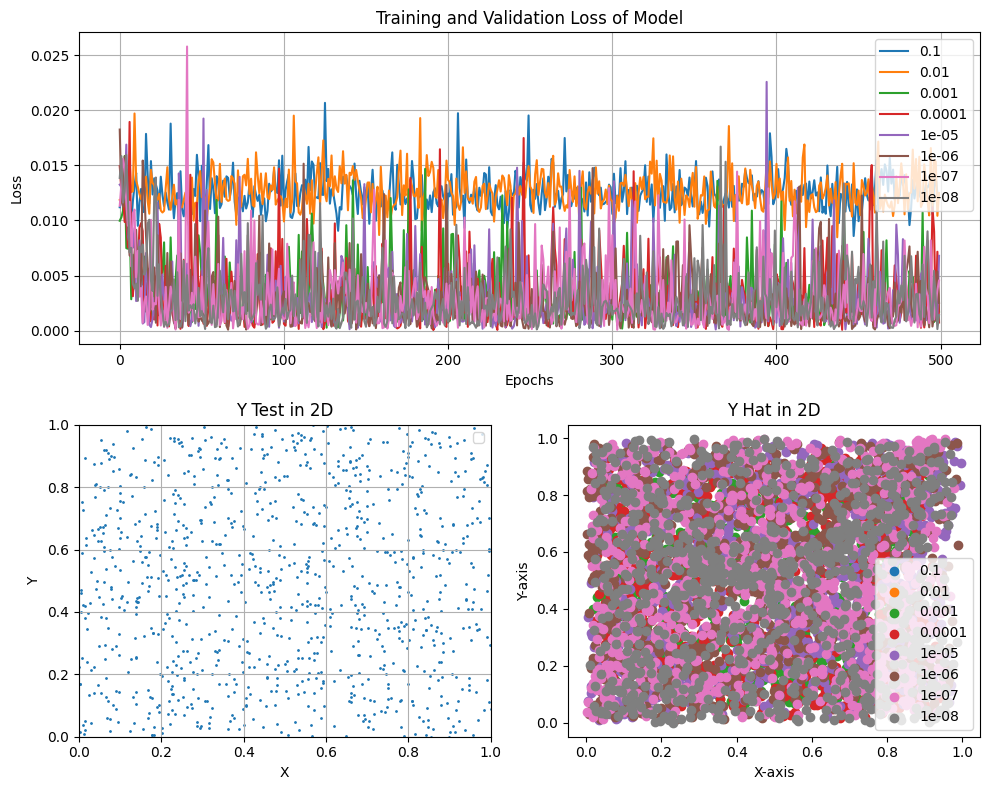

In [99]:
# Create figure
fig = plt.figure(figsize=(10, 8))

# Define the grid layout
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

# Define the axes using the grid layout
ax1 = plt.subplot(gs[0, :])  # This axis spans both columns of the first row
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

for weight_decay in weight_decaies:
    print(weight_decay)
    # Plot on the defined axes
    plot_loss(loss_history_dict[weight_decay], ax1, weight_decay)
plot_y(Y, ax2)
ax2.set_title("Y Test in 2D")
plot_pred(y_pred_dict, ax3)
ax3.set_title("Y Hat in 2D")

plt.tight_layout()
plt.show()

In [100]:
def plot(data):
    x, y = data[:, 0], data[:, 1]
    # Create a scatter plot of the data
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.2)
    plt.title('2D Gaussian Distribution')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.show()

0.1


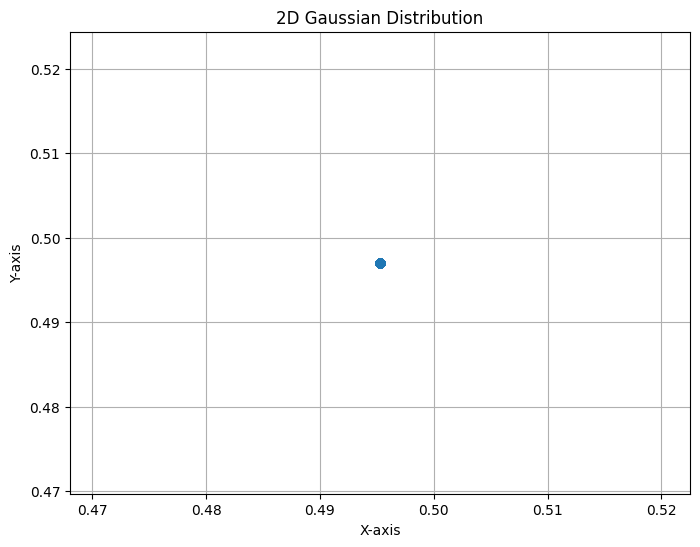

0.01


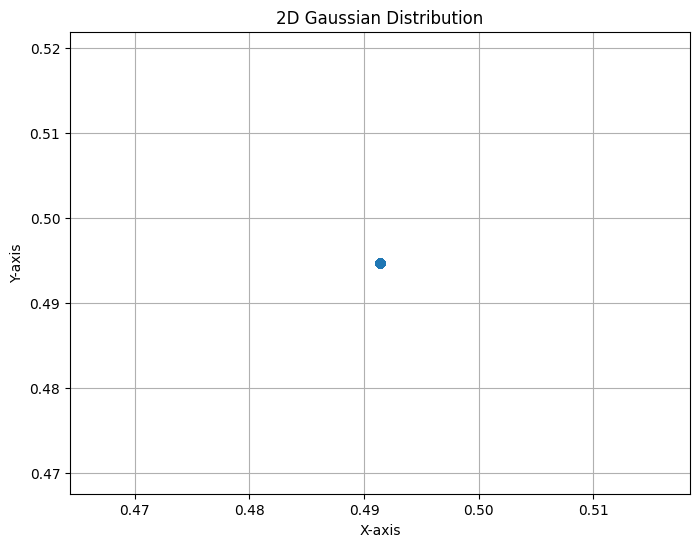

0.001


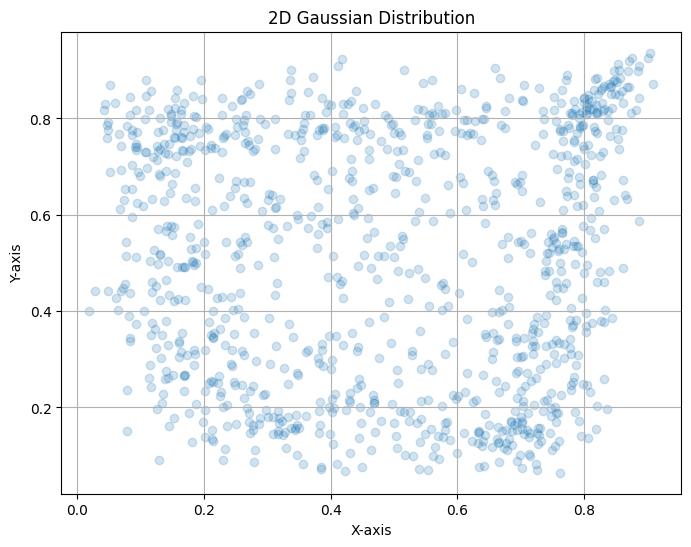

0.0001


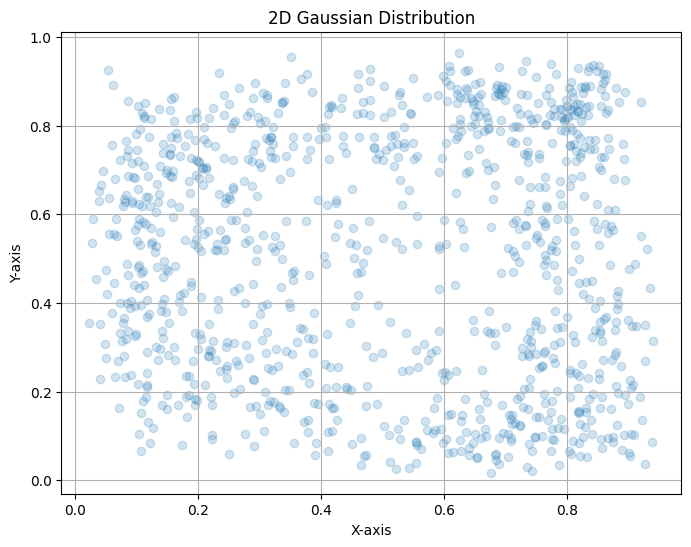

1e-05


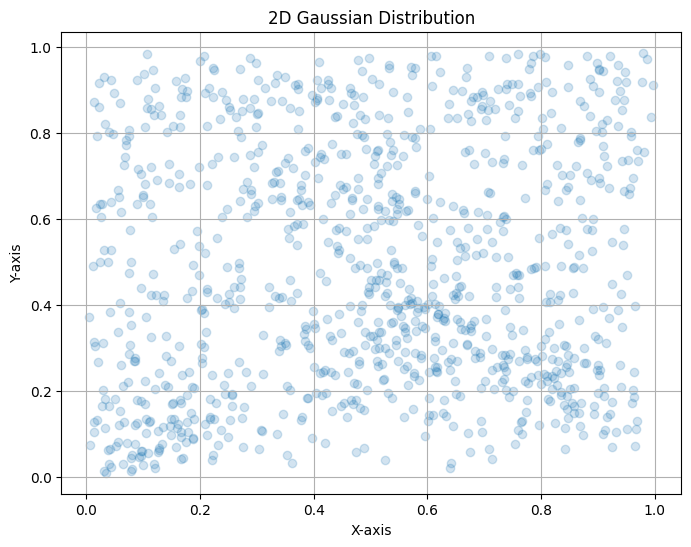

1e-06


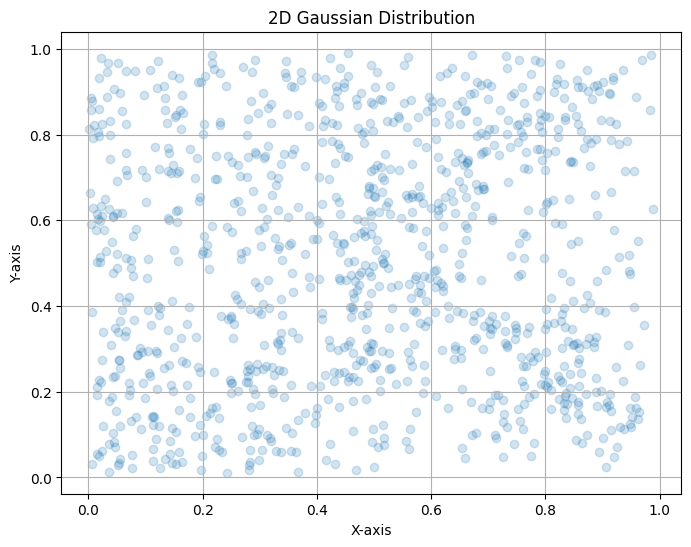

1e-07


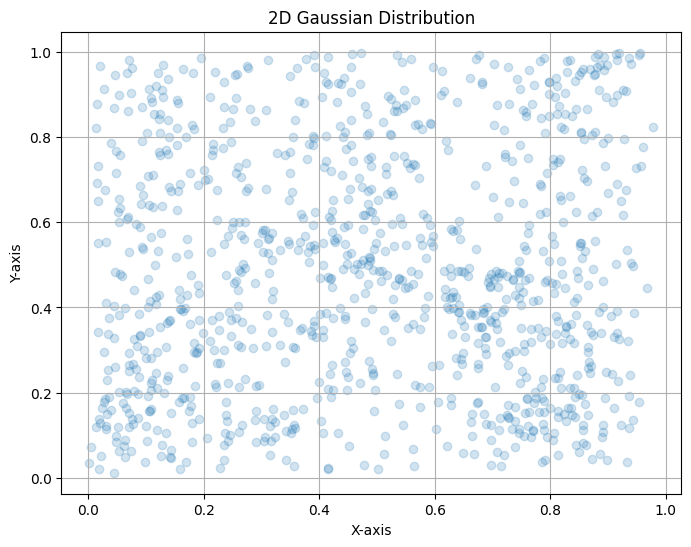

1e-08


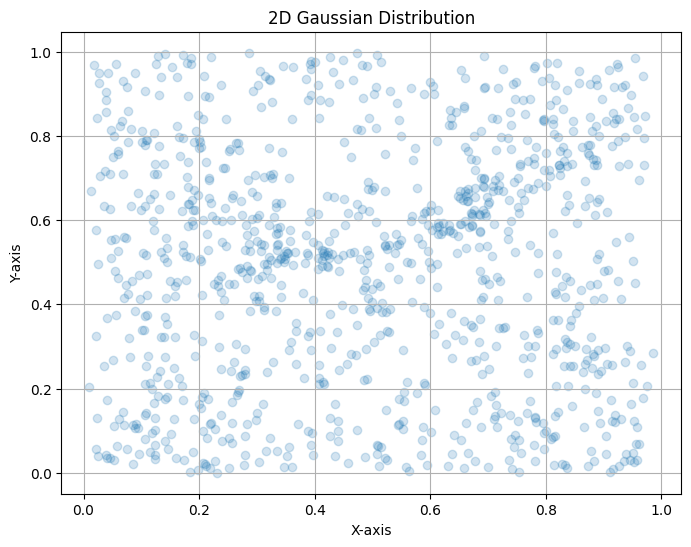

In [101]:
for label, points in y_pred_dict.items():
    print(label)
    plot(points)